# 1 Modeling Volatiliy

Find data for historical prices for any publicly traded equity. To ensure the length of data, use daily data for at least 3 years. Fit the historical data to

1. Geometric Brownian motion
2. Any non-constant volatility model

Find market data for option prices for this stock. Use option prices to

3. Show volatility smile
4. Construct term structure of volatility
5. Plot the volatility surface, as a function of time to maturity and moneyness 

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pybroker
import yfinance as yf
from pybroker.data import DataSource
from pybroker.ext.data import AKShare
import warnings
from pylab import mpl
from datetime import datetime
from scipy.optimize import minimize
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-white')
mpl.rcParams['savefig.dpi'] = 300 
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [168]:
STRAT_DATE = '2021-01-01'
END_DATE = '2024-09-30'
MSFT = yf.Ticker('MSFT') 

## Constant Volatility
If the stock price follows **Geometric Brownian Motion**, then 
$$
\begin{aligned}
d\ln(S)=\left( \mu-\frac{1}{2}\sigma^{2} \right)dt+\sigma dB
\end{aligned}
$$
hence 
$$
\begin{gathered}
\Delta \ln S =\quad\left(\mu-\frac12\sigma^2\right)\Delta t+\sigma\Delta B \\
\ln S(t_i)-\ln S(t_{i-1}) =\quad\left(\mu-\frac12\sigma^2\right)\Delta t+\sigma(B(t_i)-B(t_{i-1})) \\
\frac{\ln S(t_i)-\ln S(t_{i-1})}{\sqrt{\Delta t}} =\quad\left(\mu-\frac12\sigma^2\right)\sqrt{\Delta t}+\sigma\frac{B(t_i)-B(t_{i-1})}{\sqrt{\Delta t}} 
\end{gathered}
$$
here we let $\Delta t=1\text{ day }= 1/252 \text{ year }$ , let $y_{i}=\frac{\ln S(t_{i})-\ln S(t_{i-1})}{\sqrt{ \Delta t }}$, then 
$$
\begin{aligned}
\hat{\sigma}^{2}& =\frac{1}{N-1}\left(\sum_{i=1}^{N}y_{i}^{2}-N\bar{y}^{2}\right) \\
\end{aligned}
$$
and 
$$
\hat{\mu}=\bar{y}+\frac{1}{2}\hat{\sigma}^{2}
$$

In [169]:
# read local data
df = pd.read_csv('MSFT_stock_data.csv', index_col=0)
df.set_index('date', inplace=True)

# calculate log returns
delta_t = 1 / 252
df['y'] = np.log(df['close'] / df['close'].shift(1)) / np.sqrt(delta_t)
df.dropna(inplace=True)


### Statistic Estimations

In [170]:

# estimate parameters
y_bar = df['y'].mean()
N = len(df)
sigma_stat = np.std(df['y'])
mu_stat = y_bar/np.sqrt(delta_t) + 1 / 2 * sigma_stat ** 2

print(f"sigma_stat = {sigma_stat:.4f}")
print(f"mu_stat = {mu_stat:.4f}")

sigma_stat = 0.2637
mu_stat = 0.2162


### Maximum Likelihood Estimation

In [171]:
def GBM_log_likelihood(params, log_returns):
    mu_gbm, sigma_gbm = params
    n = len(log_returns)
    mu = (mu_gbm - 1/2 * sigma_gbm**2) * np.sqrt(delta_t)
    sigma = sigma_gbm
    log_likelihood = -n/2 * np.log(2 * np.pi * sigma**2) -\
                     1/(2 * sigma**2) * np.sum((log_returns - mu)**2)
    return -log_likelihood

initial_guess = [0.05, 0.25]
results = minimize(GBM_log_likelihood, initial_guess, args=(df['y'], ))
mu_gbm, sigma_gbm = results.x
print(f"sigma_gbm = {sigma_gbm:.4f}")
print(f"mu_gbm = {mu_gbm:.4f}")

sigma_gbm = 0.2637
mu_gbm = 0.2162


## GARCH Model

We use GARCH(1, 1) model to fit $y_{i}$, to get our conditional variance

In [172]:
import arch
garch_model = arch.arch_model(df['y'], vol='garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
df['GARCH_volatility'] =(garch_fit.conditional_volatility)
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -30.2153
Distribution:                  Normal   AIC:                           68.4307
Method:            Maximum Likelihood   BIC:                           87.8099
                                        No. Observations:                  939
Date:                Fri, Oct 18 2024   Df Residuals:                      938
Time:                        15:19:01   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0166  7.537e-03      2.198  2.797e-02 [1.791e-03,3.133e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.2710e-04  2.753e-04      1.188      0.235 [-2.125e-04,8.668e-04]
alpha[1]       0.0323  8.667e-03      3.725  1.957e-04  [1.529e-02,4.927e-02]
beta[1]        0.9627  1.025e-02     93.962      0.000      [  0.943,  0.983]
=============================================================================

Covariance estimator: robust
"""

### Plot Results

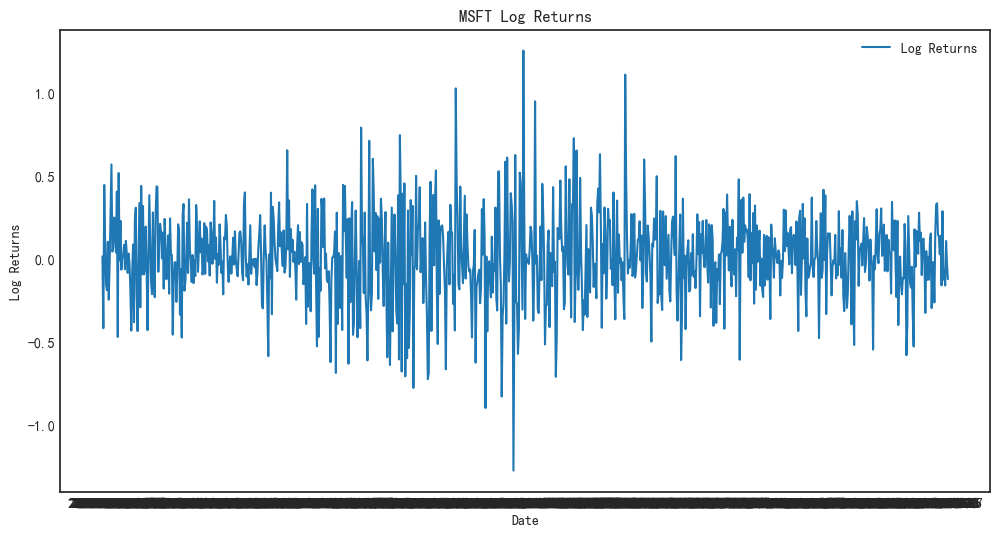

In [173]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Log Returns')
plt.title('MSFT Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

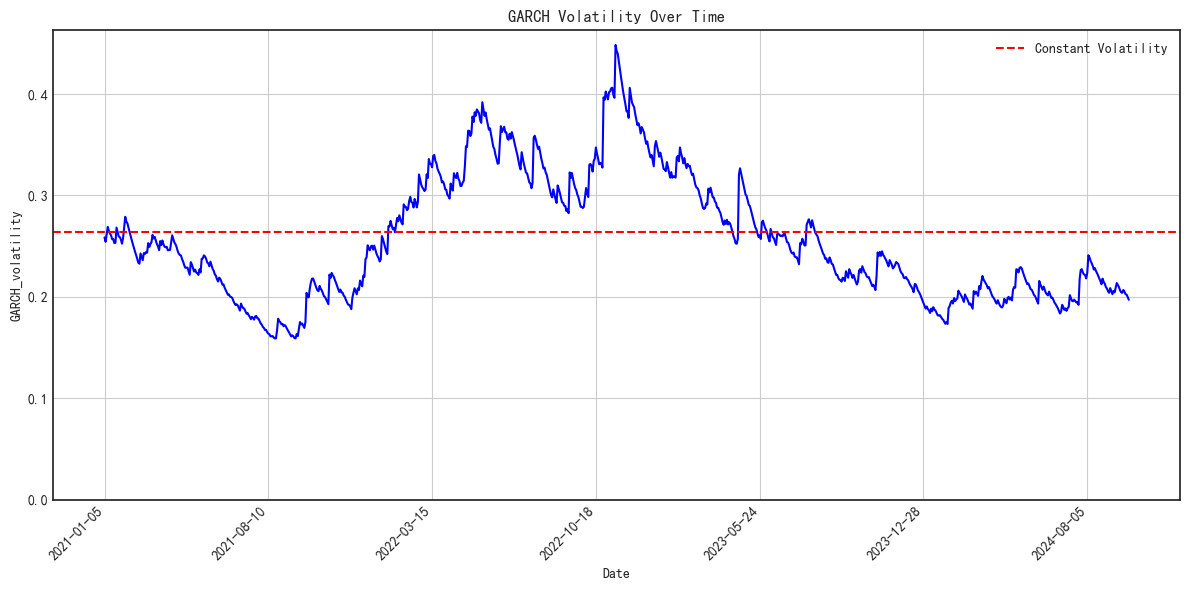

In [174]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[['GARCH_volatility']], linestyle='-', color='b')
plt.axhline(y=sigma_stat, color='r', linestyle='--', label='Constant Volatility')
plt.ylim(0)
plt.xlabel('Date')
plt.ylabel('GARCH_volatility')
plt.title('GARCH Volatility Over Time')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Reduce the number of x-axis labels
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

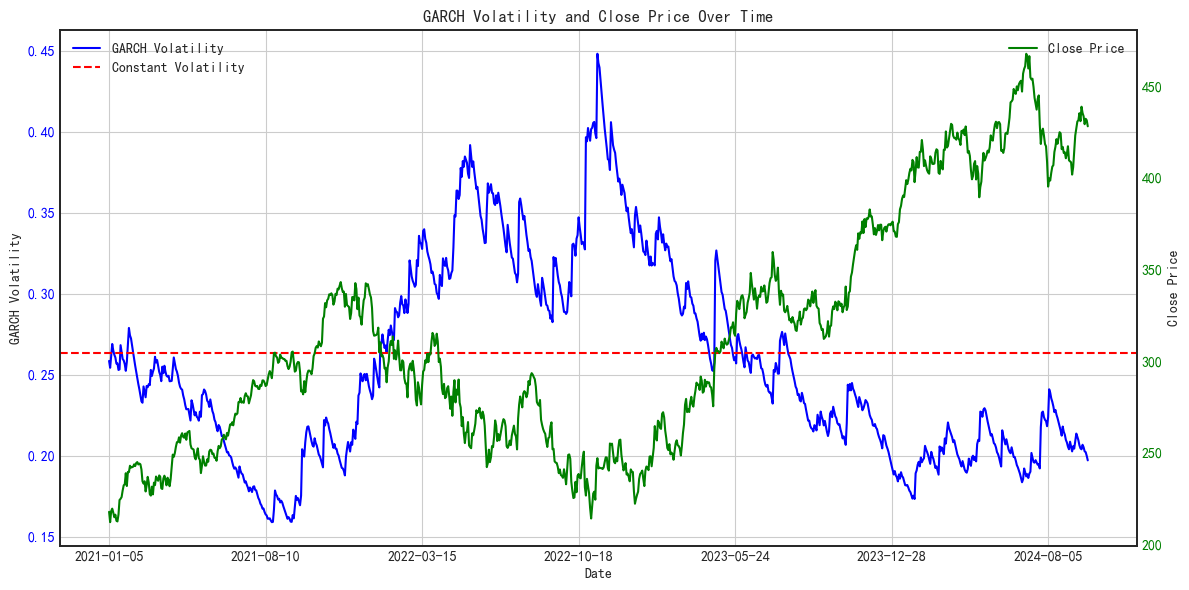

In [175]:
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax1.plot(df.index, df['GARCH_volatility'], linestyle='-', color='b', label='GARCH Volatility')
ax1.axhline(y=sigma_hat, color='r', linestyle='--', label='Constant Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('GARCH Volatility')
ax1.tick_params(axis='y', labelcolor='b')  
ax1.grid()
ax1.legend(loc='upper left')    


ax2 = ax1.twinx()
ax2.plot(df.index, df['close'], linestyle='-', color='g', label='Close Price')
ax2.set_ylabel('Close Price')
ax2.tick_params(axis='y', labelcolor='g')  
ax2.legend(loc='upper right')


plt.xticks(rotation=45, ha='right')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))  


plt.title('GARCH Volatility and Close Price Over Time')
plt.tight_layout()

plt.show()

## Volatility Smile

Find the today's call option data of MSFT, there are 15 different options. The expiration ranges from 2024 - 10 - 18 to 2026-12-18

The *TTM* ( time to maturity) needs to be converted to years, so each is divided by 365 

Since there are outliers in *impliedVolatility* 

In [184]:
df_option = pd.read_csv('call_option.csv') #Data was collected on 2024-10-16
current_price = 416.72

# choose the option date
option_columns = ['expiration', 'strike', 'last', 'impliedVolatility']
df_option = df_option[option_columns]
df_option['expiration'] = pd.to_datetime(df_option['expiration'])
df_option['impliedVolatility'] = df_option['impliedVolatility'] / 100

# calculate time to maturity (in years)
df_option['TTM'] = (df_option['expiration'] - pd.Timestamp('2024-10-16')).dt.days 
df_option['TTM'] = df_option['TTM'] / 365 # convert days to years
df_option['moneyness'] = current_price / df_option['strike']

# exclude options with implied volatility changing too dramatically
df_option = df_option[(df_option['impliedVolatility'] > 0.01) & (df_option['impliedVolatility'] < 0.6)]
df_option = df_option[df_option['impliedVolatility'].pct_change() < 0.3]

# exclude options with extreme strike price 
df_option = df_option[(df_option['strike'] > current_price * 0.8) & (df_option['strike'] < current_price * 1.5)]

#exclude options whose expiration near today or too far
df_option = df_option[(df_option['expiration'] > pd.to_datetime('2024-10-19')) & (df_option['expiration'] < pd.to_datetime('2025-12-01'))]


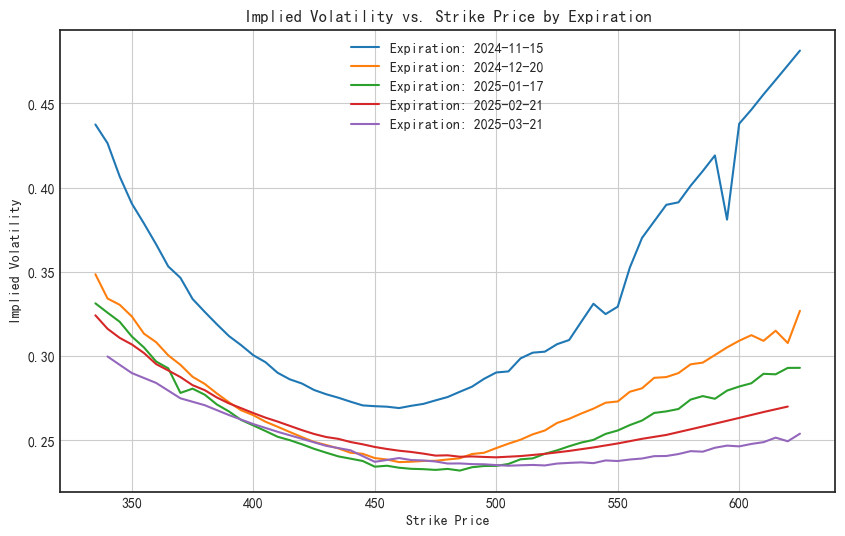

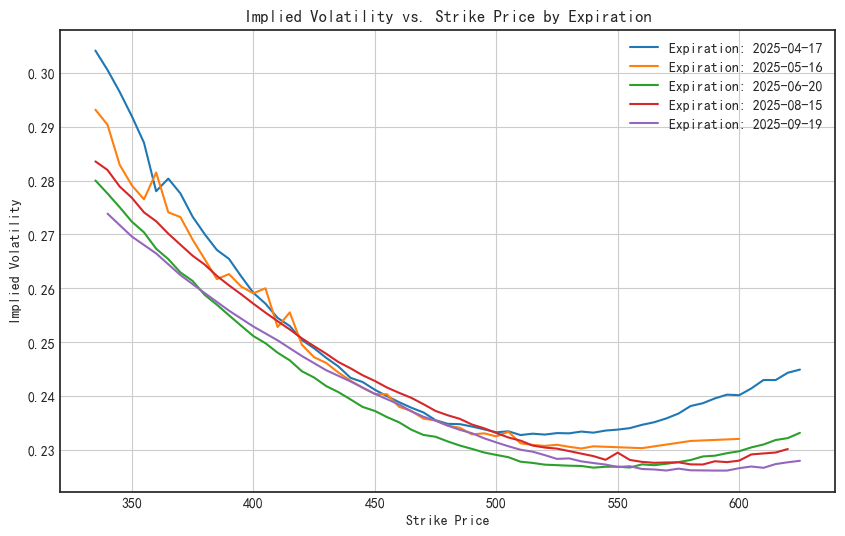

In [185]:
for i, (expiration, group) in enumerate(df_option.groupby('expiration')):
        
    if i % 5 == 0:
        plt.figure(figsize=(10, 6))
    plt.plot(group['strike'], group['impliedVolatility'], marker='', linestyle='-', label=f"Expiration: {expiration.strftime('%Y-%m-%d')}")
    if i % 5 == 4:
        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility')
        plt.title('Implied Volatility vs. Strike Price by Expiration')
        plt.legend()
        plt.grid(True)
        plt.show()

## Term Structure of Volatility

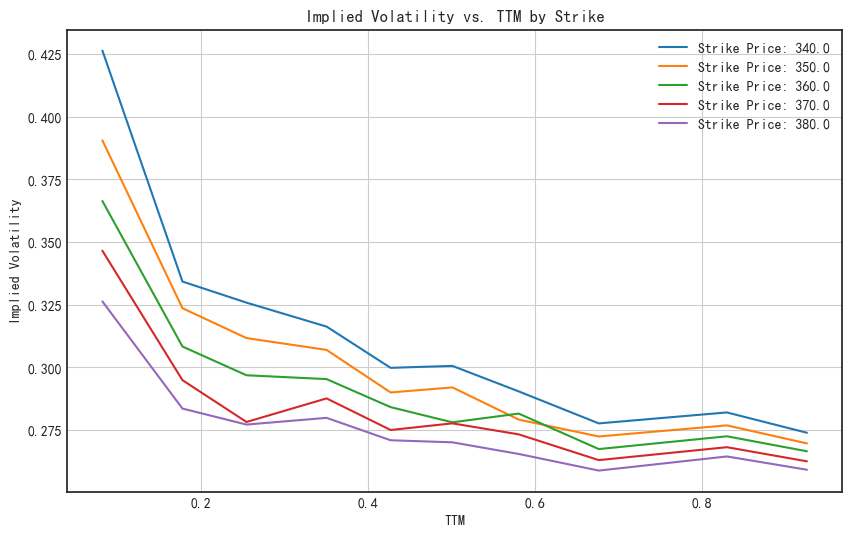

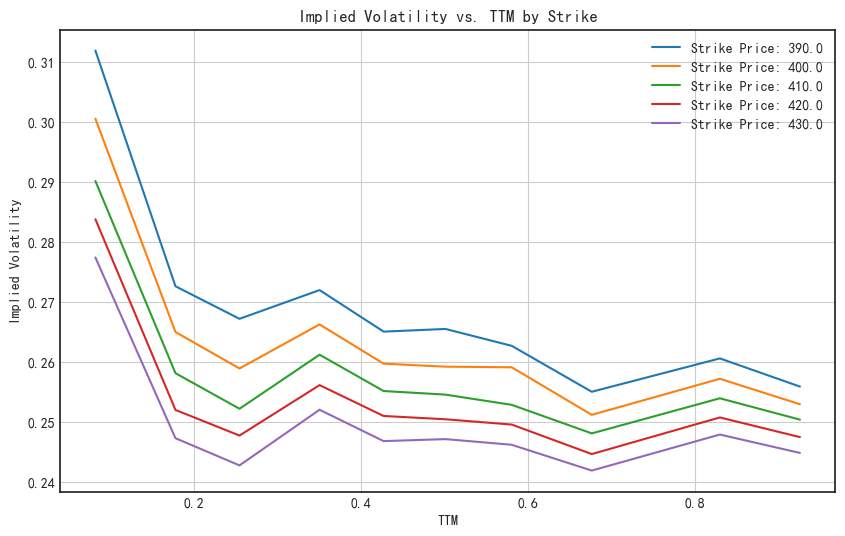

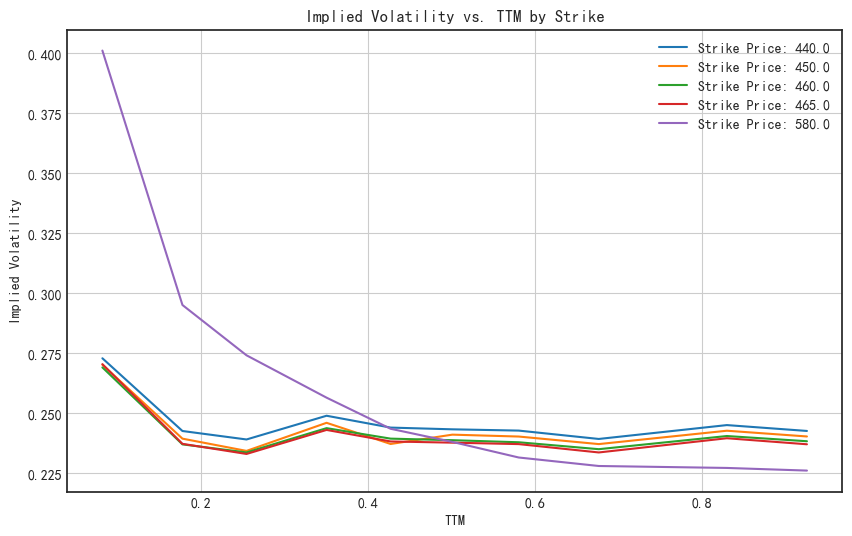

In [186]:
top_15_strikes = df_option['strike'].value_counts().head(15).index
filtered_df = df_option[df_option['strike'].isin(top_15_strikes)]

for i, (strike, group) in enumerate(filtered_df.groupby('strike')):
        
    if i % 5 == 0:
        plt.figure(figsize=(10, 6))
    plt.plot(group['TTM'], group['impliedVolatility'], marker='', linestyle='-', label=f"Strike Price: {strike}")
    if i % 5 == 4:
        plt.xlabel('TTM')
        plt.ylabel('Implied Volatility')
        plt.title('Implied Volatility vs. TTM by Strike')
        plt.legend()
        plt.grid(True)
        plt.show()

## Volatility Surface

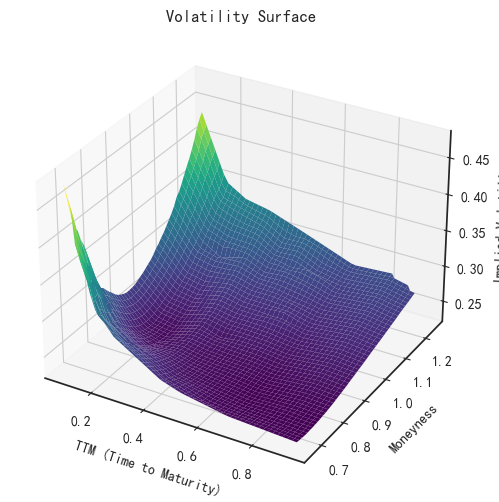

In [187]:
from scipy.interpolate import griddata

# Create a grid of TTM and moneyness
TTM_range = np.linspace(df_option['TTM'].min(), df_option['TTM'].max(), 50)
moneyness_range = np.linspace(df_option['moneyness'].min(), df_option['moneyness'].max(), 50)
TTM_grid, moneyness_grid = np.meshgrid(TTM_range, moneyness_range)

# Interpolate implied volatility onto the grid
impliedVolatility_grid = griddata(
    (df_option['TTM'], df_option['moneyness']), 
    df_option['impliedVolatility'], 
    (TTM_grid, moneyness_grid), 
    method='linear'
)

# Plotting with plot_surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(TTM_grid, moneyness_grid, impliedVolatility_grid, cmap=plt.get_cmap('viridis'), edgecolor='none')

ax.set_ylabel('Moneyness')
ax.set_xlabel('TTM (Time to Maturity)')
ax.set_zlabel('Implied Volatility')

plt.title('Volatility Surface')
plt.show()


# 2 Vanilla European option pricing

In [181]:
sigma, mu = [sigma_gbm, mu_gbm]
params = garch_fit.params
a, b, c = params[1], params[2], params[3]
print(f"sigma: {sigma:.4f}, mu: {mu:.4f}")
print(f"a: {a:.4f}, b: {b:.4f}, c: {c:.4f}")

sigma: 0.2637, mu: 0.2162
a: 0.0003, b: 0.0323, c: 0.9627


In [182]:
df

,symbol,open,high,low,close,volume,adj_close,y,GARCH_volatility
date,,,,,,,,,
2021-01-05,MSFT,217.259995,218.520004,215.699997,217.899994,23823000,211.047699,0.015306,0.258492
2021-01-06,MSFT,212.169998,216.490005,211.940002,212.250000,35930700,205.575363,-0.417045,0.254264
2021-01-07,MSFT,214.039993,219.339996,213.710007,218.289993,27694500,211.425400,0.445432,0.261978
2021-01-08,MSFT,218.679993,220.580002,217.029999,219.619995,22956200,212.713593,0.096427,0.268950
2021-01-11,MSFT,218.470001,218.910004,216.729996,217.490005,23031300,210.650589,-0.154711,0.264890
...,...,...,...,...,...,...,...,...,...
2024-09-23,MSFT,434.279999,436.459991,430.390015,433.510010,15128900,433.510010,-0.064317,0.205180
2024-09-24,MSFT,433.000000,433.350006,426.100006,429.170013,17015800,429.170013,-0.159725,0.202646
2024-09-25,MSFT,429.829987,433.119995,428.570007,432.109985,13396400,432.109985,0.108375,0.202144
